This notebook is a follow-up of "Cleanup_new_detection". The aim is to re-extract RGB from cropped imaged derived from single-class Yolov3 object detection. 
1549/1555 input images triggered detection at a threshold of 0.25. 
Though all detections have confidence percent near 100%.

In [1]:
import colorgram
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import matplotlib.colors as mcolor
from ast import literal_eval
from scipy.spatial import distance as distance
from mpl_toolkits.mplot3d import Axes3D

dir = os.getcwd()
home = os.path.dirname(os.path.dirname(dir)) ## 2 levels up of working directory dir

In [2]:
# import cropped images data that has been extensively processed.
pd_cropped = pd.read_csv(os.path.join(dir, r'darknet_detected_cropped.csv'), index_col = 0)
# 1812 cropped imaged generated from 1549 catalog images.
pd_cropped.tail()

,dn_crop,dn_order,box_order,class_name,class_id,image,index_image,crop_width,crop_height,crop_area,left_x,top_y,width,height,deviation-score,centerness-score
1807,img_1552_1808_0_Pillow.jpg.jpg,1552,1808,Pillow,0,Pillow_select/Page_9_6.jpg,Page_9_6,448,431,193088,16,27,448,431,0.694500,305.175769
1808,img_1553_1809_0_Pillow.jpg.jpg,1553,1809,Pillow,0,Pillow_select/Page_9_7.jpg,Page_9_7,417,370,154290,39,57,417,371,0.709001,278.870041
1809,img_1554_1810_0_Pillow.jpg.jpg,1554,1810,Pillow,0,Pillow_select/Page_9_8.jpg,Page_9_8,235,201,47235,218,138,235,201,1.553305,337.589247
1810,img_1554_1811_0_Pillow.jpg.jpg,1554,1811,Pillow,0,Pillow_select/Page_9_8.jpg,Page_9_8,376,276,103776,54,113,376,276,0.755217,243.287895
1811,img_1555_1812_0_Pillow.jpg.jpg,1555,1812,Pillow,0,Pillow_select/Page_9_9.jpg,Page_9_9,364,356,129584,57,67,363,357,0.731349,263.276471


In [3]:
# Bounding box with a lower deviation score is more likely to contain the cental product.
# Select one cropped image for each input catalog image using the above criterion.
pd_cropped_sort =pd_cropped.sort_values(by=['dn_order','deviation-score'])
n = pd_cropped_sort.shape[0]
judge = [0] * n
for i in range(1,n-1):
    if (
        (pd_cropped_sort['dn_order'][i]==pd_cropped_sort['dn_order'][i-1]) 
        and 
        (pd_cropped_sort['dn_order'][i+1]!=pd_cropped_sort['dn_order'][i])
       ):
        judge[i]=1
if pd_cropped_sort['dn_order'][n-1]==pd_cropped_sort['dn_order'][n-2]:
    judge[n-1]=1
    judge[n-2]=0
judge_bool = [i==0 for i in judge]

# remember to reset index after cropping
pd_cropped_select = pd_cropped_sort[judge_bool].reset_index(drop=True)

In [4]:
# move on to run colorgram on all images under the path img_dir
# initiate two empty lists
path_cropped_image = r'Yolov3_pillow/NewPrediction/result_img'
img_dir = os.path.join(home, path_cropped_image)

RGB_x = []
Proportion_x = []
RGB_y = []
Proportion_y = []

for i in range(pd_cropped_select.shape[0]):
    img_name = pd_cropped_select['dn_crop'][i]
    colors = colorgram.extract(os.path.join(img_dir,img_name),2)
    RGB_x.append(colors[0].rgb)
    Proportion_x.append(colors[0].proportion)
    if colors[0].proportion==1:
        RGB_y.append(colors[0].rgb)
        Proportion_y.append(0)
    else:
        RGB_y.append(colors[1].rgb)
        Proportion_y.append(colors[1].proportion)

pd_cropped_select['RGB_x'] = RGB_x
pd_cropped_select['Proportion_x'] = Proportion_x
pd_cropped_select['RGB_y'] = RGB_y
pd_cropped_select['Proportion_y'] = Proportion_y

export_csv = pd_cropped_select.to_csv(os.path.join(dir,r'cropped_image_RGB.csv'), index = True, header=True)    

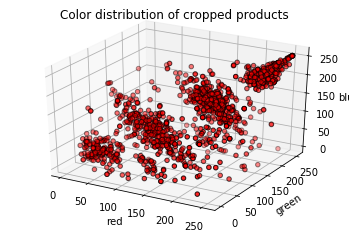

<Figure size 432x288 with 0 Axes>

In [5]:
# next, draw a 3D plot to see the distribution of products after cropping and cleaning
crop_r =[i[0] for i in pd_cropped_select['RGB_x']]
crop_g =[i[1] for i in pd_cropped_select['RGB_x']]
crop_b =[i[2] for i in pd_cropped_select['RGB_x']]

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(crop_r,crop_g,crop_b, color='r', edgecolor='k')

ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue') 

ax.set_title('Color distribution of cropped products')

plt.show()
plt.clf()

In [6]:
# import pallet file
palette_tuple = pd.read_csv(os.path.join(dir,r'palette_clean_hex.csv'), index_col = 0)

# reformat tuples after read_csv
# do the same for palette_tuple
palette_tuple['RGB1']=palette_tuple['RGB1'].apply(literal_eval)
palette_tuple['RGB2']=palette_tuple['RGB2'].apply(literal_eval)
palette_tuple['RGB3']=palette_tuple['RGB3'].apply(literal_eval)
palette_tuple['RGB4']=palette_tuple['RGB4'].apply(literal_eval)

In [7]:
# Method 1: Euclidean distance with weights [0.3,0.59,0.11]
# First, find the most similar color to user's choice from all colors in palette database
# if multiple palette colors are pulled return the one with smallest index number
# since palettes are ranked by popularity

location = []

for i in range(pd_cropped_select.shape[0]):
    
    u = list(pd_cropped_select['RGB_x'][i])

    def vv(v):
        return distance.euclidean(u, v, [0.3**2, 0.59**2, 0.11**2])

    # return a numpy 2d arrary and then the minimum value
    np_dist = np.array(palette_tuple[['RGB1','RGB2','RGB3','RGB4']].applymap(vv))
    minim = np.amin(np_dist)

    # return location of this minimum value and append to previous output
    location.append([np.where(np_dist == minim)[0][0],np.where(np_dist == minim)[1][0]])

# store location in product table
# also want to add palette name and position of the product on the palette to product table
palette_name = palette_tuple.index.values[[x[0] for x in location]]
# important to record palette_id b/c there are different palettes with the same name
palette_id = [x[0] for x in location]
position = [x[1] for x in location]
pd_cropped_select['palette_name'] = palette_name
pd_cropped_select['palette_id'] = palette_id
pd_cropped_select['position_on_pltt'] = position

export_csv = pd_cropped_select.to_csv (os.path.join(dir,r'cropped_image_RGB_plt.csv'), index = True, header=True)

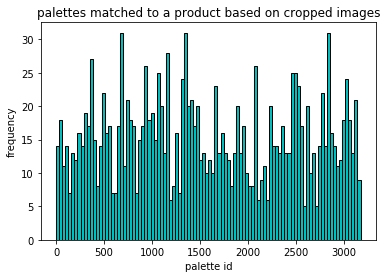

<Figure size 432x288 with 0 Axes>

In [8]:
# see distribution of palettes that match with a product
palette_matched = np.array([i[0] for i in location])

plt.hist(palette_matched, bins= 100, color='c', edgecolor='k')

plt.xlabel('palette id')
plt.ylabel('frequency')
plt.title('palettes matched to a product based on cropped images')

plt.show()
plt.clf()

In [9]:
# once a product is selected, it traces to a palette
# then find 3 more products that match with the remaining 3 colors in the palette
def getMore_rev(locRGB_love, palette_tpl, img_RGB):
    # (a) locRGB_loved is the location of the matched color on the palette data, e.g. 3 as in [1756, 3]
    # (b) palette_tpl is the 4 RGB tuples associated with locRGB_loved
    #       example: [(2, 146, 183) (26, 200, 219) (140, 117, 106) (222, 226, 236)]
    # (c) img_RGB is img_url['RGB_x']
    # when multiple products are matched for the same color, choose the one on top of the img_url list
    # since products are ranked by "Best selling"
    palette = np.delete(np.array(palette_tpl),locRGB_love)  # this is the partial palette with 3 colors left
    loc3more = []
    for i in range(3):
        rgb = palette[i]
        u = [rgb[0],rgb[1],rgb[2]]
        def vv(v):
            return distance.euclidean(u, v, [0.3**2, 0.59**2, 0.11**2])
        # go through all products
        np_dist = np.array(img_RGB.apply(vv))
        minim = np.amin (np_dist)        
        loc3more.append(np.where(np_dist == minim)[0][0])
    return loc3more

In [17]:
# initiate an empty dataframe
results = pd.DataFrame()

for i in range(pd_cropped_select.shape[0]):
    results = results.append(
        pd.DataFrame(
            getMore_rev(locRGB_love = pd_cropped_select['position_on_pltt'][i], 
                    palette_tpl = palette_tuple[['RGB1','RGB2','RGB3','RGB4']].iloc[pd_cropped_select['palette_id'][i]], 
                    img_RGB = pd_cropped_select['RGB_x'])
        ).T
    )

In [18]:
results.head()

,0,1,2
0,452,341,297
0,852,908,611
0,1184,435,217
0,1390,1070,1376
0,639,469,908


In [19]:
# need to reset index since it's 0 for all now
results=results.reset_index(drop=True)
results.rename(columns={0: 'match1', 
                       1: 'match2',
                       2: 'match3'}, inplace = True)
export_csv = results.to_csv (os.path.join(dir,r'match_result_afterYolov3.csv'), index = True, header=True)

In [20]:
output = pd_cropped_select.join(results) # always check index before joining
output["RGB_x_hex"] = ['#%02x%02x%02x' % i for i in output["RGB_x"]]

In [21]:
output.head()

,dn_crop,dn_order,box_order,class_name,class_id,image,index_image,crop_width,crop_height,crop_area,...,Proportion_x,RGB_y,Proportion_y,palette_name,position_on_pltt,palette_id,match1,match2,match3,RGB_x_hex
0,img_1_1_0_Pillow.jpg.jpg,1,1,Pillow,0,Pillow_select/Page_10_11.jpg,Page_10_11,417,360,150120,...,0.668707,"(245, 243, 240)",0.331293,Newborn Bundle,2,1169,452,341,297,#aea294
1,img_2_2_0_Pillow.jpg.jpg,2,2,Pillow,0,Pillow_select/Page_10_12.jpg,Page_10_12,401,405,162405,...,0.599385,"(146, 28, 31)",0.400615,Natural Flush,2,1838,852,908,611,#d4524f
2,img_3_3_0_Pillow.jpg.jpg,3,3,Pillow,0,Pillow_select/Page_10_13.jpg,Page_10_13,378,370,139860,...,0.806537,"(245, 245, 245)",0.193463,Seaweed Sushi,3,1086,1184,435,217,#d7d7db
3,img_4_4_0_Pillow.jpg.jpg,4,4,Pillow,0,Pillow_select/Page_10_14.jpg,Page_10_14,479,266,127414,...,0.606510,"(249, 249, 249)",0.393490,Stark Contrast,3,1857,1390,1070,1376,#131312
4,img_5_5_0_Pillow.jpg.jpg,5,5,Pillow,0,Pillow_select/Page_10_15.jpg,Page_10_15,401,390,156390,...,0.968913,"(225, 223, 224)",0.031087,Neutral Meeting Ground,3,1456,639,469,908,#e3e1df


In [22]:
export_csv = output.to_csv (os.path.join(dir,r'cropped_image_w_recommendation.csv'), index = True, header=True)

In [34]:
# Lastly, add hex format to palette file for html
#palette_tuple['hex1'] = ['#%02x%02x%02x' % i for i in palette_tuple["RGB1"]]
#palette_tuple['hex2'] = ['#%02x%02x%02x' % i for i in palette_tuple["RGB2"]]
#palette_tuple['hex3'] = ['#%02x%02x%02x' % i for i in palette_tuple["RGB3"]]
#palette_tuple['hex4'] = ['#%02x%02x%02x' % i for i in palette_tuple["RGB4"]]
#export_csv = palette_tuple.to_csv (os.path.join(dir,r'palette_clean_hex.csv'), index = True, header=True)